<a href="https://colab.research.google.com/github/Prakriti-Sahu/FoML/blob/main/ML_Assignment_3_Q4_Random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Programming Question Q4 - Random Forests**

**Importing data**

In [1]:
!wget https://web.stanford.edu/~hastie/ElemStatLearn//datasets/spam.data

--2021-10-31 08:02:21--  https://web.stanford.edu/~hastie/ElemStatLearn//datasets/spam.data
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200, 2607:f6d0:0:925a::ab43:d7c8
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 698341 (682K)
Saving to: ‘spam.data’

spam.data           100%[===================>] 681.97K   908KB/s    in 0.8s    

2021-10-31 08:02:22 (908 KB/s) - ‘spam.data’ saved [698341/698341]



**Importing necessary libraries**

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

**Reading data**

In [30]:
header_list=np.arange(58)
data=pd.read_csv("spam.data",sep='\s+',names=header_list)
data.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


**Defining functions to calculate entropy, perform split, info gain**

In [70]:
# calclating entropy
def entropy(col):
    counts=np.unique(col,return_counts=True) 
    N=float(col.shape[0]) 
    ent=0.0
    for i in counts[1]:
        p=i/N
        ent +=(-1.0 *p*np.log2(p)) 
    return ent


# performing split on nodes
def divide(x_data,key,threshold):
  
  x_left=pd.DataFrame([],columns=x_data.columns) 
  x_right=pd.DataFrame([],columns=x_data.columns) 
 
  for i in range(x_data.shape[0]):
    val=x_data[key].loc[i]
    if(val>threshold): 
      x_right=x_right.append(x_data.loc[i]) # val>threshhold implies left subtree
    else:
      x_left=x_left.append(x_data.loc[i]) # val<=threshhold implies right subtree
  
  
  return x_left,x_right


# calculating info gain
def info_gain(x_data,key,threshold):
  left,right=divide(x_data,key,threshold) # splitting the data to different nodes
  l=float(left.shape[0]/x_data.shape[0])
  r=float(right.shape[0]/x_data.shape[0])

  if(left.shape[0]==0 or right.shape[0]==0): 
    #self.target=1 
    return -1000000

  i_gain=entropy(x_data[57])-(l*entropy(left[57])+r*entropy(right[57])) 
    
  return i_gain

**Implementing the tree**

In [71]:
class DecisionTree:


    # defining the tree structure
    def __init__(self,depth=0,max_depth=8):
        self.left=None
        self.right=None
        self.fkey=None
        self.fval=None
        self.max_depth=max_depth
        self.depth=depth
        self.features=None
        self.target=None



    # training the data
    def train(self,x_data):

      features=x_data.columns
      self.features=features
      info_gains=[]
      for i in features[:-2]: 
        i_gain=info_gain(x_data,i,x_data[i].median()) 
        info_gains.append(i_gain)

      
      self.fkey=features[np.argmax(info_gains)]  # key for split is max info gain
      self.fval=x_data[self.fkey].median()
      left,right=divide(x_data,self.fkey,self.fval) # performing split

      left=left.reset_index(drop=True)
      right=right.reset_index(drop=True)

      print("\nLEFT: ",left.shape[0],"RIGHT: ",right.shape[0])
      print("Depth: ",self.depth)

      if(left.shape[0]==0 or right.shape[0]==0):
        self.target=1
      
      if(left.shape[0]<20 and right.shape[0]<20): 
        if(x_data[57].mean()>=0.5):
          self.target=1
        else:
          self.target=0
  
        return
      elif(x_data.shape[0]<30):
        if(x_data[57].mean()>=0.5):
          self.target=1
        else:
          self.target=0
      elif(entropy(x_data[57])<0.05):
        if(x_data[57].mean()>=0.5):
          self.target=1
        else:
          self.target=0
      elif(self.depth >=self.max_depth): 
        if(x_data[57].mean()>=0.5):
          self.target=1
        else:
          self.target=0
  
        return
      else:      
        self.left=DecisionTree(depth=self.depth+1,max_depth=8) 
        self.left.train(left)  # training left subtree
        self.right=DecisionTree(depth=self.depth+1,max_depth=8) 
        self.right.train(right) # training right subtree
        if(x_data[57].mean()>=0.5):
          self.target=1
        else:
          self.target=0
        return
    

    # predicting test data
    def predict(self,test):
      if(test[self.fkey]>=self.fval):
        if self.right is None:
          return self.target
        return self.right.predict(test)
      else:
        if self.left is None:
          return self.target
        return self.left.predict(test)

**Getting rid of outliers**

In [49]:
cols=[0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56]

X=data[cols]
y=data[57]
print(f"Dimensions od dataset: {X.shape,y.shape}")
# Performing split on data, into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(f"Dimensions of train data: {X_train.shape}\nDimensions of test data: {X_test.shape}")

Dimensions od dataset: ((4601, 57), (4601,))
Dimensions of train data: (3220, 57)
Dimensions of test data: (1381, 57)


In [50]:
x_train=pd.concat([X_train,y_train],axis=1)
x_test=pd.concat([X_test,y_test],axis=1)
x_train.reset_index(drop=True,inplace=True)
x_test.reset_index(drop=True,inplace=True)

**Implementation with in-built Classifier**

In [51]:
# Gaussian Classifier with 20 estimators
clf=RandomForestClassifier(n_estimators=20)

# training model
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
acc=np.sum(y_pred==y_test)/y_pred.shape
print(f"Accuracy: {acc}")

Accuracy: [0.94279508]


**Selecting features**

In [52]:
print(f"Important features: {clf.feature_importances_}")
df=pd.DataFrame(clf.feature_importances_,index=data.columns[:-1],columns=['Importance'])
# arranging features according to importance, to perform feature selection 
df=df.sort_values(by='Importance',ascending=False)

Important features: [2.40028814e-03 6.45662511e-03 1.40797250e-02 9.15119076e-04
 3.08793044e-02 6.99668008e-03 1.03289228e-01 1.27033439e-02
 4.15433618e-03 7.03679460e-03 1.29587665e-02 1.14395853e-02
 3.78721120e-03 1.30554200e-03 1.97789531e-03 5.87608262e-02
 2.51456213e-02 1.03201072e-02 2.48983572e-02 3.16688861e-03
 4.88926121e-02 1.78768570e-03 1.37476182e-02 3.11775159e-02
 4.65814159e-02 1.63843356e-02 1.52994735e-02 3.92468064e-03
 2.41204839e-03 2.39847557e-03 1.57060479e-03 2.28325570e-04
 3.97575300e-03 1.41486073e-04 5.84720022e-03 1.87541407e-03
 1.11112234e-02 4.95102087e-04 4.47358763e-03 1.81683313e-03
 1.00975177e-03 6.63847868e-03 2.44992370e-03 1.92113099e-03
 7.63374661e-03 1.38668124e-02 3.88785022e-04 1.38866431e-03
 5.28764670e-03 1.26563221e-02 2.22316323e-03 1.46220939e-01
 5.50473756e-02 5.00202067e-03 7.52211923e-02 5.56149118e-02
 5.06154974e-02]


In [53]:
cols=df.head(35).index.values
train_d=x_train[cols]
t=pd.concat([train_d,x_train[57]],axis=1)

**Model training**

In [54]:
dt=DecisionTree()
dt.train(t)


LEFT:  1638 RIGHT:  1582
Depth:  0

LEFT:  1560 RIGHT:  78
Depth:  1

LEFT:  1113 RIGHT:  447
Depth:  2

LEFT:  749 RIGHT:  364
Depth:  3

LEFT:  675 RIGHT:  74
Depth:  4

LEFT:  612 RIGHT:  63
Depth:  5

LEFT:  347 RIGHT:  265
Depth:  6

LEFT:  177 RIGHT:  170
Depth:  7

LEFT:  150 RIGHT:  27
Depth:  8

LEFT:  86 RIGHT:  84
Depth:  8

LEFT:  215 RIGHT:  50
Depth:  7

LEFT:  109 RIGHT:  106
Depth:  8

LEFT:  25 RIGHT:  25
Depth:  8

LEFT:  35 RIGHT:  28
Depth:  6

LEFT:  24 RIGHT:  11
Depth:  7

LEFT:  22 RIGHT:  2
Depth:  8

LEFT:  6 RIGHT:  5
Depth:  8

LEFT:  14 RIGHT:  14
Depth:  7

LEFT:  37 RIGHT:  37
Depth:  5

LEFT:  24 RIGHT:  13
Depth:  6

LEFT:  17 RIGHT:  7
Depth:  7

LEFT:  8 RIGHT:  5
Depth:  7

LEFT:  33 RIGHT:  4
Depth:  6

LEFT:  32 RIGHT:  1
Depth:  7

LEFT:  16 RIGHT:  16
Depth:  8

LEFT:  1 RIGHT:  0
Depth:  8

LEFT:  2 RIGHT:  2
Depth:  7

LEFT:  270 RIGHT:  94
Depth:  4

LEFT:  135 RIGHT:  135
Depth:  5

LEFT:  81 RIGHT:  13
Depth:  5

LEFT:  64 RIGHT:  17
Depth:

**Predicting for test data**

In [56]:
a=[]
test_data_2=x_test
for i in range(test_data_2.shape[0]):
  test_data_2['predicted']=dt.predict(test_data_2.iloc[i])
  a.append(dt.predict(test_data_2.iloc[i]))

print(a)
ab=pd.DataFrame(a,columns=['p'])
xy=pd.concat([test_data_2,ab],axis=1)

acc1=np.sum(test_data_2['predicted']==test_data_2[57])/test_data_2.shape[0]
acc2=np.sum(xy['p']==xy[57])/xy.shape[0]
print(a)
print("\nAccuracy:")
print(acc2)

[1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 

**Getting rid of outliers**

In [63]:
def delete(x,upper,lower):
  if(x>upper):x=np.nan
  elif(x<lower):x=np.nan
  return x

for i in cols:
  temp=x_train[i]
  upper=np.percentile(temp,[99.6])[0]
  lower=np.percentile(temp,[1])[0]
  x_train[i]=temp.apply(delete,args=(upper,lower))

x_train=x_train.dropna()


t=x_train[cols]
t=pd.concat([t,x_train[57]],axis=1)
t.reset_index(drop=True,inplace=True)

In [64]:
c=[0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
   34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,51, 52, 53, 54, 55, 56]
for i in c:
  upper=np.percentile(data[i],[99])[0]
  lower=np.percentile(data[i],[1])[0]
  data[i]=data[i].apply(delete,args=(upper,lower))
data=data.dropna()

In [65]:
col_=df.head(35).index.values
print(f"Features:\n{col_}")

Features:
[51  6 54 15 55 52 56 20 24 23  4 16 18 25 26  2 45 22 10  7 49 11 36 17
 44  9  5 41  1 34 48 53 38  8 32]


**Calculating out-of-bag error**

In [72]:
arr=[]
out_of_bag_err=[]

for i in range(20):
  # creating decision tree
  arr.append(i) 
  arr[i]=DecisionTree()

  # random feature selection 
  index=np.random.randint(0,35,20)
  features=col_[index]
  f=set(features)
  print(f"\nFeatures selected: {f}")

  # selecting random data
  rows=np.random.randint(0,x_train.shape[0],1500)
  y=x_train.iloc[rows][57]

  train_data=x_train.iloc[rows]
  train_data=train_data[f]
  train_data2=pd.concat([train_data,y],axis=1)

  train_data2.reset_index(drop=True,inplace=True)  
  t=train_data2[:1000]
  out_bag=train_data2[1001:]
  t.reset_index(drop=True,inplace=True)
  out_bag.reset_index(drop=True,inplace=True)

  arr[i].train(t)
  y=[]
  for j in range(out_bag.shape[0]):
    y.append(arr[i].predict(out_bag.iloc[j]))
  
  acc=np.sum(y==out_bag[57])/out_bag.shape[0]
  out_of_bag_err.append(1-acc)
  print(f"Trained {i}")

print(f"\nOut of bag error: {np.mean(out_of_bag_err)}")


Features selected: {34, 5, 7, 8, 41, 11, 15, 48, 16, 49, 52, 20, 22, 55, 56}

LEFT:  695 RIGHT:  305
Depth:  0

LEFT:  541 RIGHT:  154
Depth:  1

LEFT:  346 RIGHT:  195
Depth:  2

LEFT:  176 RIGHT:  170
Depth:  3

LEFT:  128 RIGHT:  48
Depth:  4

LEFT:  92 RIGHT:  36
Depth:  5

LEFT:  49 RIGHT:  43
Depth:  6

LEFT:  31 RIGHT:  18
Depth:  7

LEFT:  29 RIGHT:  2
Depth:  8

LEFT:  17 RIGHT:  1
Depth:  8

LEFT:  41 RIGHT:  2
Depth:  7

LEFT:  18 RIGHT:  18
Depth:  6

LEFT:  47 RIGHT:  1
Depth:  5

LEFT:  123 RIGHT:  47
Depth:  4

LEFT:  101 RIGHT:  22
Depth:  5

LEFT:  98 RIGHT:  3
Depth:  6

LEFT:  88 RIGHT:  10
Depth:  7

LEFT:  86 RIGHT:  2
Depth:  8

LEFT:  7 RIGHT:  3
Depth:  8

LEFT:  2 RIGHT:  1
Depth:  7

LEFT:  16 RIGHT:  6
Depth:  6

LEFT:  24 RIGHT:  23
Depth:  5

LEFT:  155 RIGHT:  40
Depth:  3

LEFT:  130 RIGHT:  25
Depth:  4

LEFT:  71 RIGHT:  59
Depth:  5

LEFT:  46 RIGHT:  25
Depth:  6

LEFT:  24 RIGHT:  22
Depth:  7

LEFT:  23 RIGHT:  1
Depth:  8

LEFT:  12 RIGHT:  10
Dep

In [73]:
test_data1=x_test
b=[]
for j in range(test_data1.shape[0]):
  pred=[]
  for i in range(20):
    pred.append(arr[i].predict(test_data1.iloc[j]))
  prediction=np.mean(pred)
  print("Prediction:",prediction)
  if(prediction>=0.5):b.append(1)
  else:b.append(0)
ba=pd.DataFrame(b,columns=['p'])
bb=pd.concat([test_data1,ba],axis=1)
acc=np.sum(bb['p']==bb[57])/bb.shape[0]
print(f"Accuracy: {acc}")

Prediction: 0.45
Prediction: 0.4
Prediction: 0.4
Prediction: 0.45
Prediction: 0.45
Prediction: 0.4
Prediction: 0.35
Prediction: 0.35
Prediction: 0.4
Prediction: 0.4
Prediction: 0.35
Prediction: 0.35
Prediction: 0.4
Prediction: 0.35
Prediction: 0.4
Prediction: 0.4
Prediction: 0.35
Prediction: 0.45
Prediction: 0.35
Prediction: 0.35
Prediction: 0.35
Prediction: 0.35
Prediction: 0.45
Prediction: 0.35
Prediction: 0.35
Prediction: 0.4
Prediction: 0.35
Prediction: 0.35
Prediction: 0.35
Prediction: 0.4
Prediction: 0.35
Prediction: 0.35
Prediction: 0.35
Prediction: 0.35
Prediction: 0.35
Prediction: 0.35
Prediction: 0.45
Prediction: 0.4
Prediction: 0.45
Prediction: 0.4
Prediction: 0.45
Prediction: 0.35
Prediction: 0.35
Prediction: 0.35
Prediction: 0.4
Prediction: 0.35
Prediction: 0.4
Prediction: 0.45
Prediction: 0.45
Prediction: 0.45
Prediction: 0.4
Prediction: 0.45
Prediction: 0.4
Prediction: 0.35
Prediction: 0.35
Prediction: 0.4
Prediction: 0.4
Prediction: 0.35
Prediction: 0.35
Prediction: 0.3

## **Varying the number of features used for split**

In [86]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

cols=[0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56]

X=data[cols]
y=data[57]

# Performing split on data, into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [93]:
# Gaussian Classifier with m=number of features=auto selected features
clf=RandomForestClassifier(n_estimators=20, max_features='auto')

# training model
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
acc=np.sum(y_pred==y_test)/y_pred.shape
print(f"Accuracy: {acc}")

Accuracy: [0.94064748]


In [96]:
# Gaussian Classifier with m=number of features=log2 of total features
clf=RandomForestClassifier(n_estimators=20, max_features='log2')

# training model
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
acc=np.sum(y_pred==y_test)/y_pred.shape
print(f"Accuracy: {acc}")

Accuracy: [0.93705036]


In [100]:
# Gaussian Classifier with m=number of features=sqrt of total features
clf=RandomForestClassifier(n_estimators=20, max_features='sqrt')

# training model
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
acc=np.sum(y_pred==y_test)/y_pred.shape
print(f"Accuracy: {acc}")

Accuracy: [0.95143885]


In [107]:
X_train.shape

(1297, 57)

In [118]:
# Gaussian Classifier with m=number of features=10 to 56

acar=[]
l=[]

for i in range(10, 57, 1):
  clf=RandomForestClassifier(n_estimators=20, max_features=i)
  # training model
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  acc=np.sum(y_pred==y_test)/y_pred.shape
  acar.append(acc)
  l.append(i)
  print(f"Accuracy with {i} features: {acc}")

Accuracy with 10 features: [0.94604317]
Accuracy with 11 features: [0.94784173]
Accuracy with 12 features: [0.94784173]
Accuracy with 13 features: [0.93884892]
Accuracy with 14 features: [0.93705036]
Accuracy with 15 features: [0.94064748]
Accuracy with 16 features: [0.9442446]
Accuracy with 17 features: [0.93884892]
Accuracy with 18 features: [0.92805755]
Accuracy with 19 features: [0.9442446]
Accuracy with 20 features: [0.94244604]
Accuracy with 21 features: [0.92985612]
Accuracy with 22 features: [0.9352518]
Accuracy with 23 features: [0.93705036]
Accuracy with 24 features: [0.92985612]
Accuracy with 25 features: [0.93345324]
Accuracy with 26 features: [0.94604317]
Accuracy with 27 features: [0.94244604]
Accuracy with 28 features: [0.93884892]
Accuracy with 29 features: [0.94244604]
Accuracy with 30 features: [0.94064748]
Accuracy with 31 features: [0.94064748]
Accuracy with 32 features: [0.94604317]
Accuracy with 33 features: [0.93705036]
Accuracy with 34 features: [0.94244604]
Acc

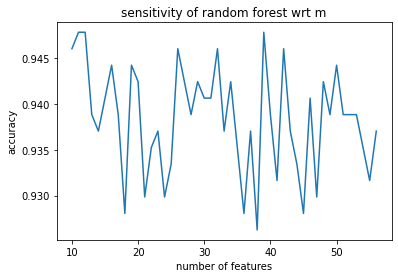

In [120]:
g=[10,11,12,13,14,15]

plt.plot(l,acar)
plt.title('sensitivity of random forest wrt m')
plt.xlabel('number of features')
plt.ylabel('accuracy')
plt.show()